<a href="https://colab.research.google.com/github/LukasMut/AlignedReps/blob/plotting-notebooks/plot_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
ROOT = "/content/drive/MyDrive/AlignedReps/AlignedReps"

Mounted at /content/drive/


In [3]:
%load_ext autoreload
%autoreload 2
import os
import pickle
from itertools import product
import numpy as np
import pandas as pd
from typing import Any, List, Tuple
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
GLOCAL_GRID = {
    "optim":["sgd"], 
    "eta":[0.01, 0.001], 
    "lmbda":[10.0, 1.0, 0.1], 
    "alpha":[0.25, 0.1], 
    "tau":[1.0, 0.5], 
    "contrastive_batch_size":[1024]
}
GLOBAL_GRID = {
    "optim":["adam"],#, None], # TODO change to adam 
    "eta":[0.0001, 1e-05], 
    "lmbda":[100.0, 10.0, 1.0, 0.1, 0.001, 0.0001], 
    "alpha":[None], 
    "tau":[None], 
    "contrastive_batch_size":[None]
}
MODEL2PRETTY = {
    "alexnet": "AlexNet", 
    "resnet18": "ResNet-18", 
    "resnet50": "ResNet-50",
    "vgg16": "VGG-16", 
    "clip_RN50": "CLIP-RN50", 
    "clip_ViT-L/14": "CLIP-ViT-L/14 (WIT)", 
    "OpenCLIP_ViT-L-14_laion400m_e32": "CLIP-ViT-L/14 (LAION-400M)", 
    "OpenCLIP_ViT-L-14_laion2b_s32b_b82k": "CLIP-ViT-L/14 (LAION-2B)" 
}
MODEL2SRC = {
    "alexnet": "torchvision", 
    "resnet18": "torchvision", 
    "resnet50": "torchvision",
    "vgg16": "torchvision", 
    "clip_RN50": "custom", 
    "clip_ViT-L/14": "custom", 
    "OpenCLIP_ViT-L-14_laion400m_e32": "custom", 
    "OpenCLIP_ViT-L-14_laion2b_s32b_b82k": "custom" 
}

def get_configs_data(data):
    params = ["optim", "eta", "lmbda", "alpha", "tau", "contrastive_batch_size"]
    cfgs = list(set([tuple([d[p] for p in params]) for _,d in data.iterrows()]))
    to_return = []
    for cfg in cfgs:
        sub_data = data
        for p in params:
            cfg_p = cfg[params.index(p)]
            if cfg_p is None or (type(cfg_p) != str and np.isnan(cfg_p)):
                sub_data = sub_data[sub_data[p].isna()]
            else:
                sub_data = sub_data[sub_data[p] == cfg_p]
        if len(sub_data)>0:
            to_return.append(sub_data)
    return to_return

def get_fs_data(glocal=True):
    fs_results = pd.read_pickle(os.path.join(ROOT, f"fs_results_glo{'c' if glocal else 'b'}al.pkl"))
    del fs_results["classes"]
    tasks_fs = [i for i in fs_results["dataset"].unique()]
    datas_fs = []
    for fs_task in tasks_fs:
        datas_fs.append(fs_results[fs_results["dataset"] == fs_task])       
    return datas_fs, tasks_fs

def get_ad_data(glocal=True):
    ad_results = pd.read_csv(os.path.join(ROOT, f"ad_results_glo{'c' if glocal else 'b'}al.csv"))  
    tasks_ad = [i for i in ad_results["dataset"].unique()]
    ad_models = [i for i in ad_results["model"].unique()]
    if glocal:
      ad_results["eta"] = ad_results["transform"].str.split('/').str[-6]
      ad_results["lmbda"] = ad_results["transform"].str.split('/').str[-5]
      ad_results["alpha"] = ad_results["transform"].str.split('/').str[-4]
      ad_results["tau"] = ad_results["transform"].str.split('/').str[-3]
      ad_results["contrastive_batch_size"] = ad_results["transform"].str.split('/').str[-2]
    else:
      ad_results["eta"] = ad_results["transform"].str.split('/').str[-2]
      ad_results["lmbda"] = ad_results["transform"].str.split('/').str[-4]
      ad_results["alpha"] = None
      ad_results["tau"] = None
      ad_results["contrastive_batch_size"] = None
    ad_results['model'] = ad_results['model'].replace('clip_ViT-L-14', 'clip_ViT-L/14')
    ad_results['model_pretty'] = ad_results['model'].replace(MODEL2PRETTY)
    
    ad_results["ad_auc_t"] = ad_results["mean_auc"].astype(float)
    for column in ['eta', 'lmbda', 'tau', 'contrastive_batch_size', 'alpha']:
      ad_results[column] = ad_results[column].astype(float)

    # Filter to grid
    # TODO: filter to larger grid for imagenet models
    ad_results = ad_results[((ad_results.eta.isin(GLOBAL_GRID["eta"])) & (ad_results.lmbda.isin(GLOBAL_GRID["lmbda"])) & (ad_results.tau.isin(GLOBAL_GRID["tau"])) & (ad_results.contrastive_batch_size.isin(GLOBAL_GRID["contrastive_batch_size"])) & (ad_results.alpha.isin(GLOBAL_GRID["alpha"]))) | ((ad_results.eta.isin(GLOCAL_GRID["eta"])) & (ad_results.lmbda.isin(GLOCAL_GRID["lmbda"])) & (ad_results.tau.isin(GLOCAL_GRID["tau"])) & (ad_results.contrastive_batch_size.isin(GLOCAL_GRID["contrastive_batch_size"])) & (ad_results.alpha.isin(GLOCAL_GRID["alpha"])))]
    datas_ad = []
    for ad_task in tasks_ad:
        datas_ad.append(ad_results[ad_results["dataset"] == ad_task])   
    return datas_ad, tasks_ad

In [5]:
models = [k for k in MODEL2PRETTY.keys()]
srcs = [MODEL2SRC[m] for m in models]
module="penultimate"

print("### Loading FS data")
datas_fs, tasks_fs = get_fs_data()
datas_global_fs, _, = get_fs_data(glocal=False)
# Filter coarse/fine
task_fs_is_super = [("entity" in t) or ("coarse" in t) for t in tasks_fs]
datas_fs_c = [data[data.samples_per_superclass==sps] for data, sps in zip(datas_fs, task_fs_is_super) if sps]
datas_global_fs_c = [data[data.samples_per_superclass==sps] for data, sps in zip(datas_global_fs, task_fs_is_super) if sps]
datas_fs_f = [data[data.samples_per_superclass==sps] for data, sps in zip(datas_fs, task_fs_is_super) if not sps]
datas_global_fs_f = [data[data.samples_per_superclass==sps] for data, sps in zip(datas_global_fs, task_fs_is_super) if not sps]

print("### Loading AD data")
datas_ad, tasks_ad = get_ad_data()
datas_global_ad, _ = get_ad_data(glocal=False)

### Loading FS data
### Loading AD data


In [ ]:
datas_ad[0].head()

,dataset,model,transform,mean_auc,eta,lmbda,alpha,tau,contrastive_batch_size,model_pretty,ad_auc_t
18,cifar10,clip_ViT-L/14,/home/space/datasets/things/probing/results/cu...,0.971153,0.001,10.0,0.10,1.0,1024.0,CLIP-ViT-L/14 (WIT),0.971153
20,cifar10,clip_ViT-L/14,/home/space/datasets/things/probing/results/cu...,0.971124,0.001,10.0,0.10,0.5,1024.0,CLIP-ViT-L/14 (WIT),0.971124
30,cifar10,clip_ViT-L/14,/home/space/datasets/things/probing/results/cu...,0.970171,0.001,10.0,0.25,1.0,1024.0,CLIP-ViT-L/14 (WIT),0.970171
32,cifar10,clip_ViT-L/14,/home/space/datasets/things/probing/results/cu...,0.970095,0.001,10.0,0.25,0.5,1024.0,CLIP-ViT-L/14 (WIT),0.970095
39,cifar10,clip_ViT-L/14,/home/space/datasets/things/probing/results/cu...,0.981596,0.001,0.1,0.10,1.0,1024.0,CLIP-ViT-L/14 (WIT),0.981596


In [ ]:
datas_fs[0].head()

,model,module,source,family,dataset,transform,n_train,regressor,samples_per_superclass,optim,eta,lmbda,alpha,tau,contrastive_batch_size,glocal,model_pretty,fs_accuracy_t,fs_accuracy
0,clip_RN50,penultimate,custom,CLIP,entity13,False,2,ridge,False,sgd,0.01,0.1,0.25,0.5,1024.0,True,CLIP-RN50,0.732615,0.715877
1,clip_RN50,penultimate,custom,CLIP,entity13,False,2,ridge,False,sgd,0.001,0.1,0.1,1.0,1024.0,True,CLIP-RN50,0.740523,0.715877
2,clip_RN50,penultimate,custom,CLIP,entity13,False,2,ridge,False,sgd,0.01,10.0,0.1,1.0,1024.0,True,CLIP-RN50,0.721192,0.719904
3,clip_RN50,penultimate,custom,CLIP,entity13,False,2,ridge,False,sgd,0.001,1.0,0.25,1.0,1024.0,True,CLIP-RN50,0.730215,0.715877
4,clip_RN50,penultimate,custom,CLIP,entity13,False,2,ridge,False,sgd,0.01,10.0,0.1,0.5,1024.0,True,CLIP-RN50,0.723442,0.719192


Plotting

In [6]:
# Here we can set style settings, palettes, ...
sns.set_style("white")
sns.set_context("paper")


In [7]:
def plot_fs(data_avg, task):
    shots = list(set(data_avg.n_train))
    regressors = list(set(data_avg.regressor))
    models = list(set(data_avg.model))
    spss=list(set(data_avg.samples_per_superclass))
    n_s = len(shots)
    n_r = len(regressors)

    for sps in spss:
        fig, axs = plt.subplots(n_r,n_s,figsize=(4*n_s, 4*n_r))
        if n_s==1:
            axs = np.array([axs])
        if n_r==1:
            axs = np.array([[ax] for ax in axs])
        for s_i,s in enumerate(shots):
            for r_i, r in enumerate(regressors):
                data_avgc = data_avg[(data_avg["regressor"]==r) & (data_avg["n_train"]==s) & (data_avg["samples_per_superclass"]==sps)]
                minv = min(np.min(data_avgc["fs_accuracy"]), np.min(data_avgc["fs_accuracy_t"]))
                maxv = max(np.max(data_avgc["fs_accuracy"]), np.max(data_avgc["fs_accuracy_t"]))
                sns.scatterplot(data_avgc, 
                            x="fs_accuracy",
                            y="fs_accuracy_t",
                            hue="model_pretty", 
                            ax=axs[s_i, r_i],
                            palette="deep")
                minv-=0.025
                maxv+=0.025
                axs[s_i, r_i].set_title(f"{task}\n" + f" {s}-shot (per-super={sps}) {r}")
                axs[s_i, r_i].set_xlim([minv, maxv])
                axs[s_i, r_i].set_xlabel("Accuracy")
                axs[s_i, r_i].set_ylim([minv, maxv])
                axs[s_i, r_i].set_ylabel("Transformed Accuracy")
                axs[s_i, r_i].plot(axs[s_i, r_i].get_xlim(), 
                                   axs[s_i, r_i].get_ylim(), 
                                   "--", alpha=0.8, color="grey", zorder=0)

                if s_i == len(shots) - 1:
                    axs[s_i, r_i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')    
                else:
                    axs[s_i, r_i].get_legend().remove()
        plt.tight_layout()
        plt.show()

def plot_adfs(datas_ad, tasks_ad, datas_fs, n_shots=2, regressor="ridge", sps=False, models=None):
    n = len(datas_ad)
    m = len(datas_fs)
    palette = plt.colormaps['viridis']

    fig, axs = plt.subplots(n,m,figsize=(4*m, 3*n))
    if n==1:
        axs = np.array([axs])
    if m==1:
        axs = np.array([[ax] for ax in axs])

    models = models if models is not None else datas_fs[0].model.unique()

    tasks_fs = list([set(data.dataset) for data in datas_fs])
    

    for i_ad, (ad_data, ad_task) in enumerate(zip(datas_ad, tasks_ad)):
        for i_fs, (fs_data, fs_task) in enumerate(zip(datas_fs, tasks_fs)):
            fs_data = fs_data[(fs_data["regressor"]==regressor) & (fs_data["n_train"]==n_shots) & (fs_data["samples_per_superclass"]==sps)]

            for m_i, model in enumerate(models):
                color = palette(m_i / (len(models)))
                x_data = fs_data[fs_data["model"]==model].copy()
                y_data = ad_data[ad_data["model"]==model].copy()
                joint = x_data.merge(y_data, on=['eta', 'lmbda', 'tau', 'contrastive_batch_size', 'alpha'], how='inner')
                x = joint["fs_accuracy_t"]
                y = joint["ad_auc_t"]

                if len(x) == 0:
                    print("No joint data..")
                    continue
                #print(len(joint), "joint data points")

                axs[i_ad, i_fs].scatter(x, y, color=[color]*len(x), label=MODEL2PRETTY[model])
                if i_ad == len(tasks_ad)-1:
                    axs[i_ad, i_fs].set_xlabel(f"FS Acc {fs_task}" + (" (sps)" if sps else ""))
                if i_fs == 0:
                    axs[i_ad, i_fs].set_ylabel(f"AD AUC {ad_task}")

                axs[i_ad, i_fs].legend()        
    plt.tight_layout()
    plt.show()
    
def plot_adfs_corr(datas_ad, tasks_ad, datas_fs, n_shots=2, regressor="ridge", sps=False, models=None):
    n = len(datas_ad)
    m = len(datas_fs)
    palette = plt.colormaps['viridis']

    models = models if models is not None else datas_fs[0].model.unique()
    tasks_fs = list([set(data.dataset) for data in datas_fs])

    for m_i, model in enumerate(models):
        corrs = np.zeros([n,m])
        for i_ad, (ad_data, ad_task) in enumerate(zip(datas_ad, tasks_ad)):
            for i_fs, (fs_data, fs_task) in enumerate(zip(datas_fs, tasks_fs)):
                fs_data = fs_data[(fs_data["regressor"]==regressor) & (fs_data["n_train"]==n_shots) & (fs_data["samples_per_superclass"]==sps)]
                x_data = fs_data[fs_data["model"]==model].copy()
                y_data = ad_data[ad_data["model"]==model].copy()
                joint = x_data.merge(y_data, on=['eta', 'lmbda', 'tau', 'contrastive_batch_size', 'alpha'], how='inner')
                corrs[i_ad, i_fs] = np.corrcoef(joint["fs_accuracy_t"], joint["ad_auc_t"])[0,1]

        sns.heatmap(
                data=corrs,
                annot=True,
                #cbar=True, #True if cbar else False,
                square=True,
                xticklabels=True, #'auto',
                yticklabels=True, #'auto',
                alpha=.8,
                cmap=sns.color_palette("flare", as_cmap=True),
        )
        plt.xlabel('')
        axis = plt.gca()
        axis.set_yticks(0.5 + np.arange(len(tasks_ad)))
        axis.set_yticklabels(tasks_ad, rotation=40, ha="right", rotation_mode="anchor")
        axis.set_xticks(0.5 + np.arange(len(tasks_fs)))
        axis.set_xticklabels(tasks_fs, rotation=40, ha="right", rotation_mode="anchor")
        plt.tight_layout()
        plt.title("Task correlations for %s" %model)
        plt.show()
    
def plot_fs_glob(datas, datas_glob, tasks, n_shots=2, regressor="ridge", sps=False, models=None):
    n = len(datas)
    m = 1#len(datas_glob)
    models = models if models is not None else datas_fs[0].model.unique()

    fig, axs = plt.subplots(n,m,figsize=(4*m, 3*n))
    if n==1:
        axs = np.array([axs])
    if m==1:
        axs = np.array([[ax] for ax in axs])
        
    for i1, (data, task1) in enumerate(zip(datas, tasks)):
        i2=0
        data_glob=datas_glob[i1]
        task2=task1
        datac = data[(data["regressor"]==regressor) & (data["n_train"]==n_shots) & (data["samples_per_superclass"]==sps)].copy()
        data_globc = data_glob[(data_glob["regressor"]==regressor) & (data_glob["n_train"]==n_shots) & (data_glob["samples_per_superclass"]==sps)].copy()
        for column in ['eta', 'lmbda', 'tau', 'contrastive_batch_size', 'alpha']:
                data_globc[column] = data_globc[column].astype(float)
        joint = pd.concat([datac,data_globc])
        
        sns.boxplot(data=joint, 
                    y="fs_accuracy_t", 
                    x="model_pretty", 
                    hue="glocal", 
                    ax=axs[i1, i2],
                    palette="deep")

        dataset1 = datac["dataset"].unique()[0]
        dataset2 = data_globc["dataset"].unique()[0]
        
        axs[i1, i2].set_xlabel("Model")

        if i2 == 0:
            axs[i1, i2].set_ylabel(task2 + (" (sps)" if sps else ""))
        else:
            axs[i1, i2].set_ylabel(None)
        print(models)
        axs[i1, i2].set_xticklabels(models, rotation=40, ha="right", rotation_mode="anchor")

    plt.legend()        
    plt.tight_layout()
    plt.show()

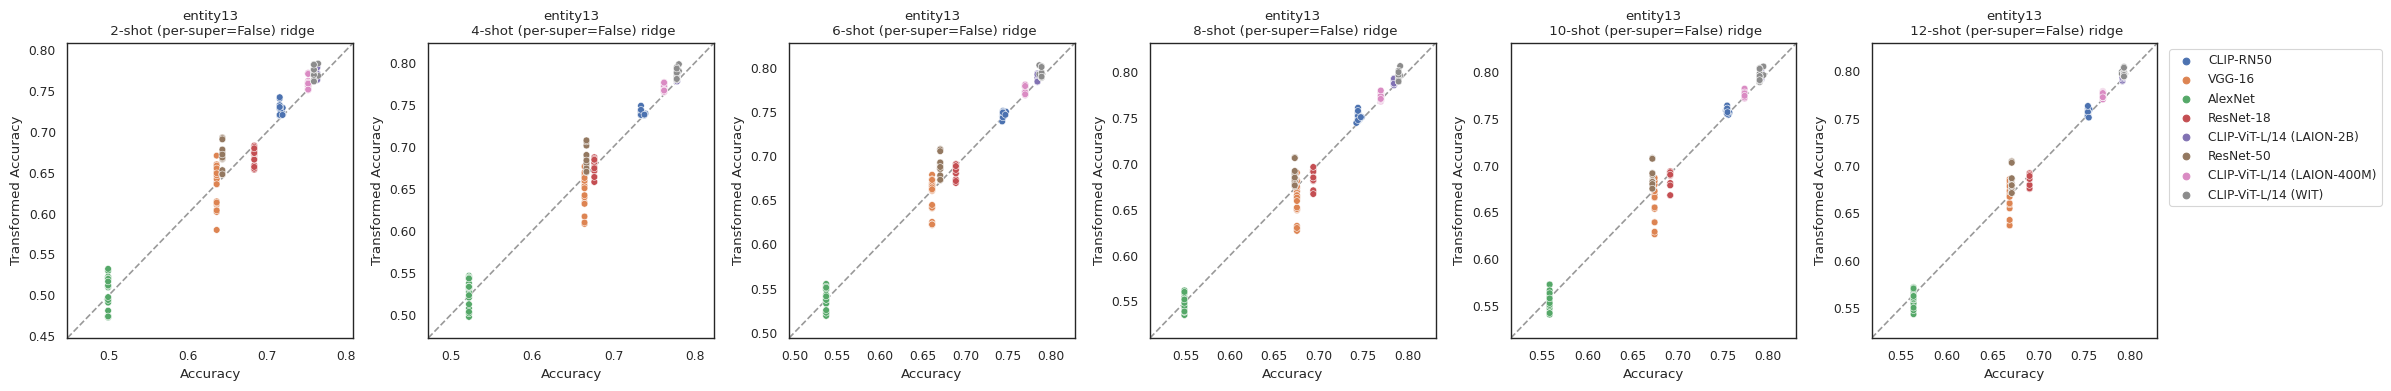

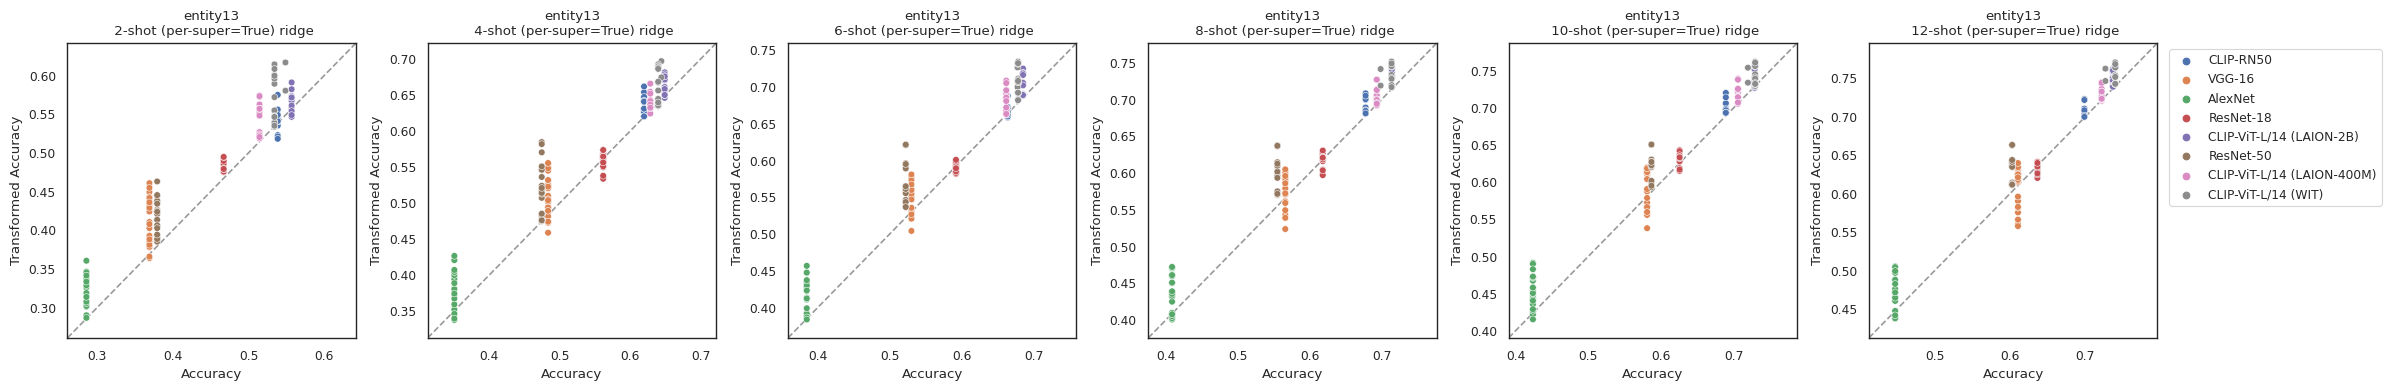

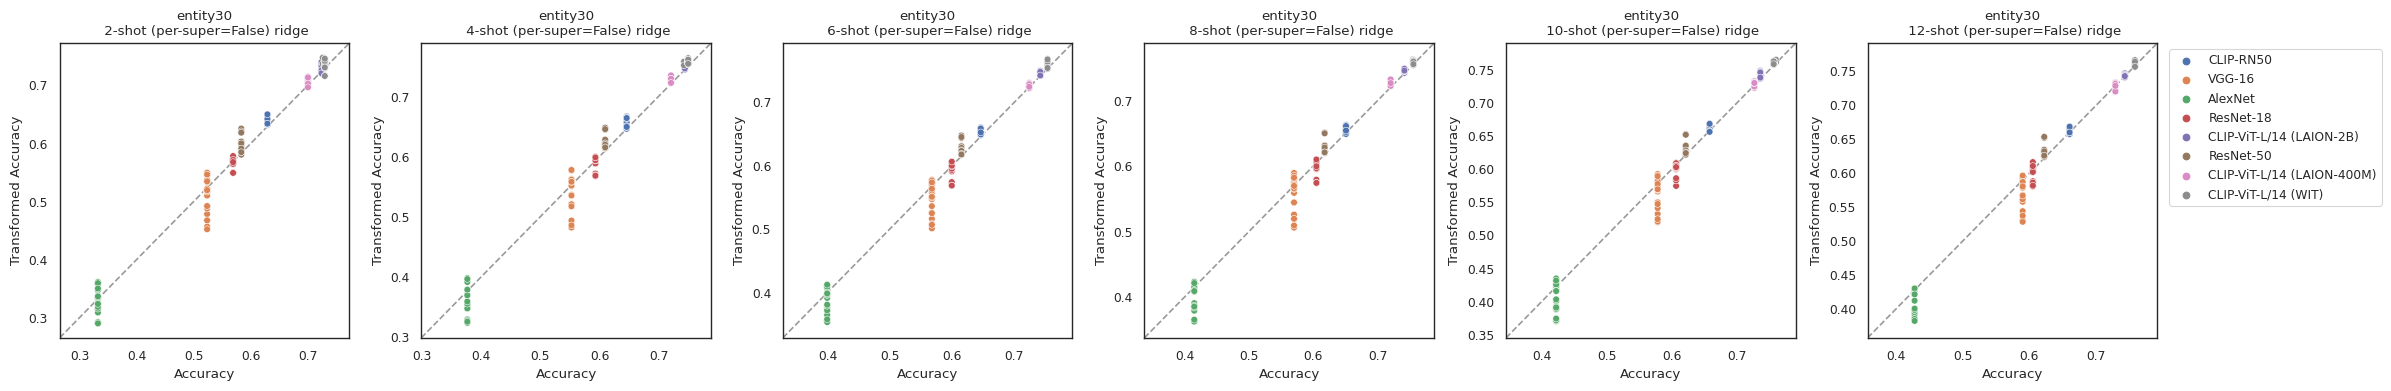

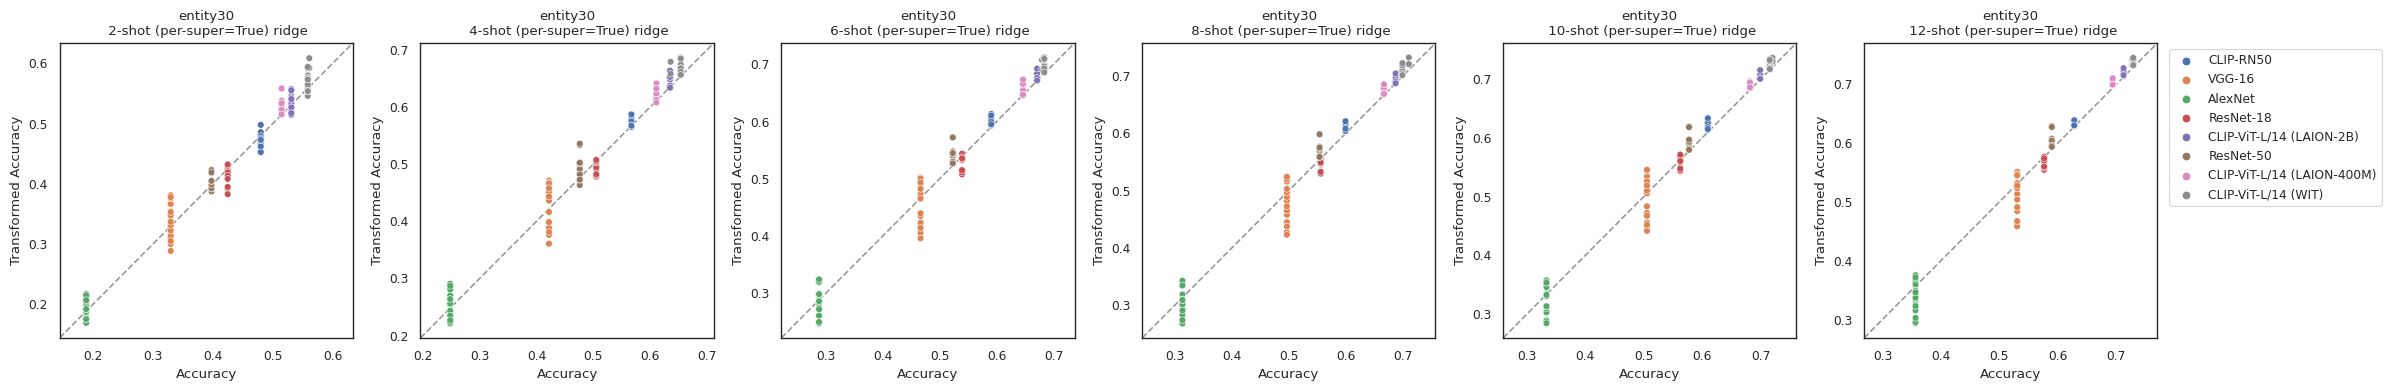

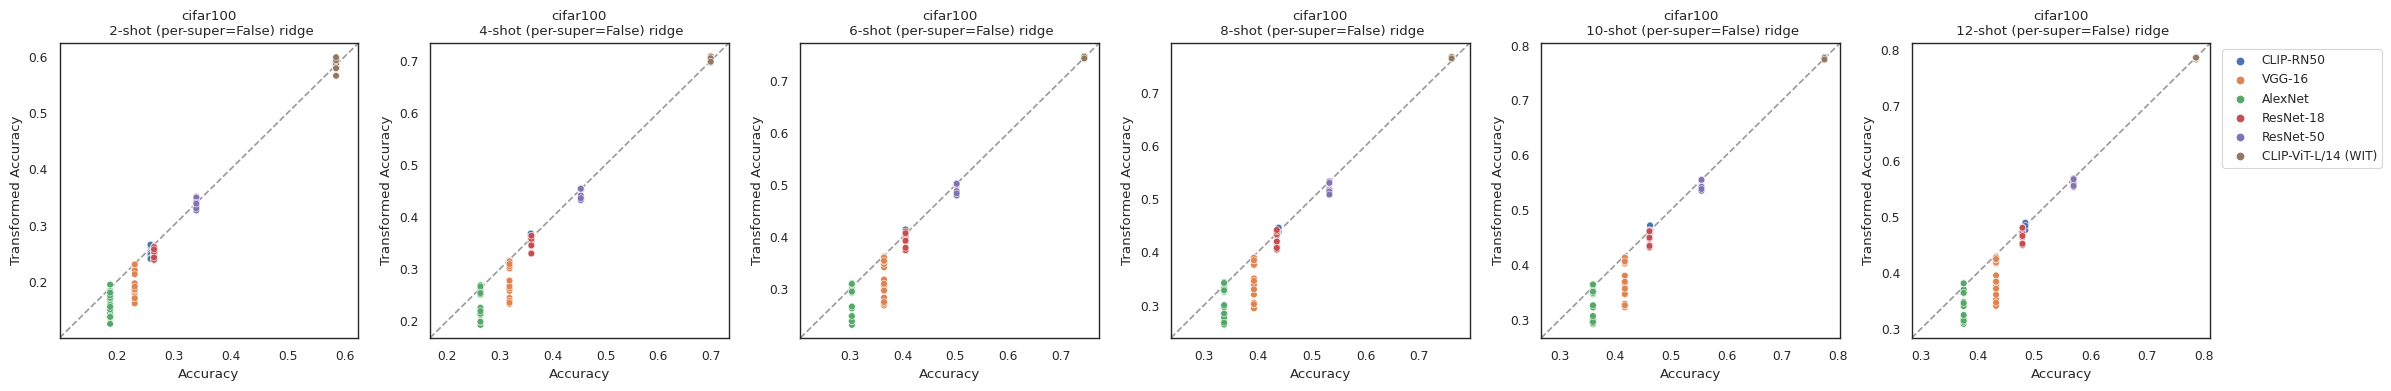

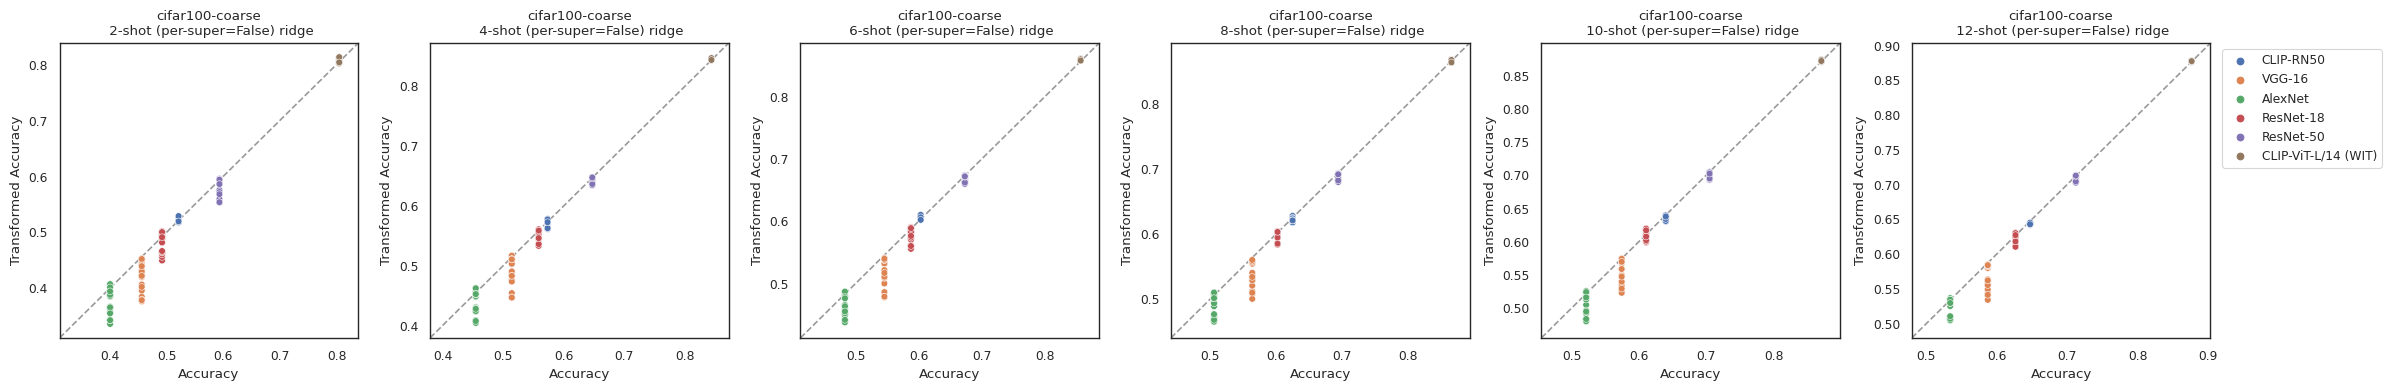

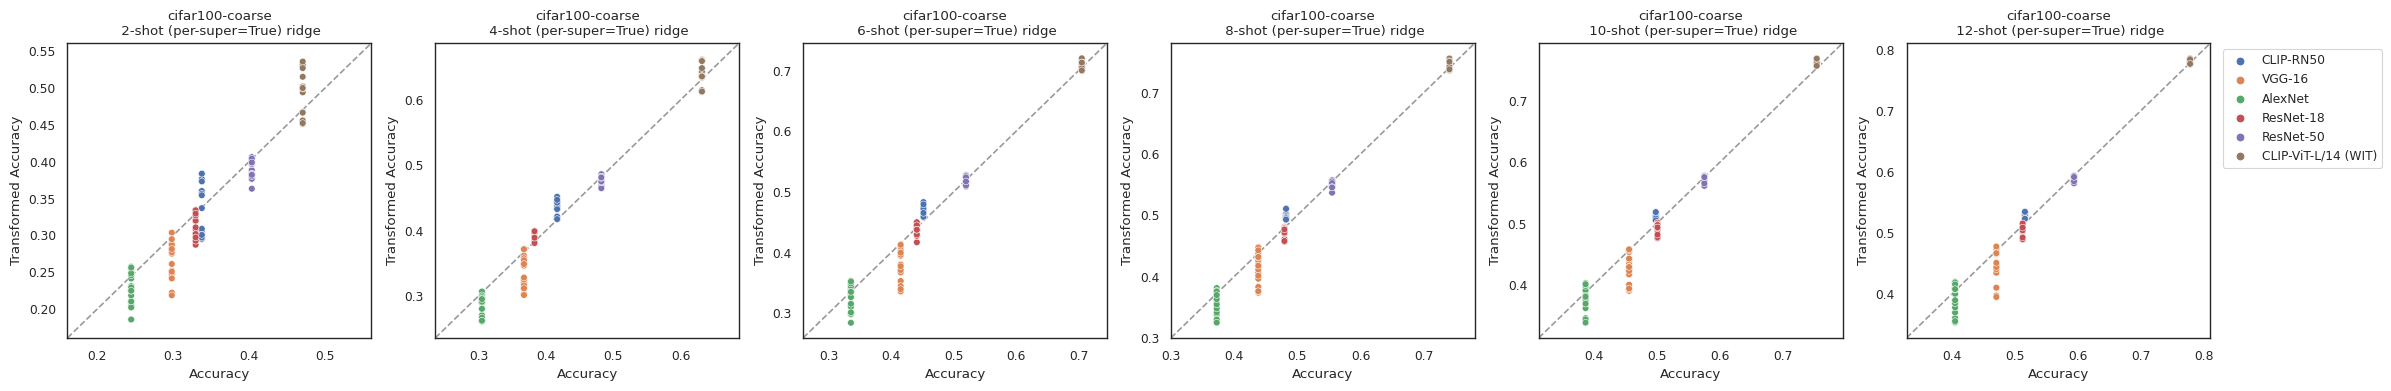

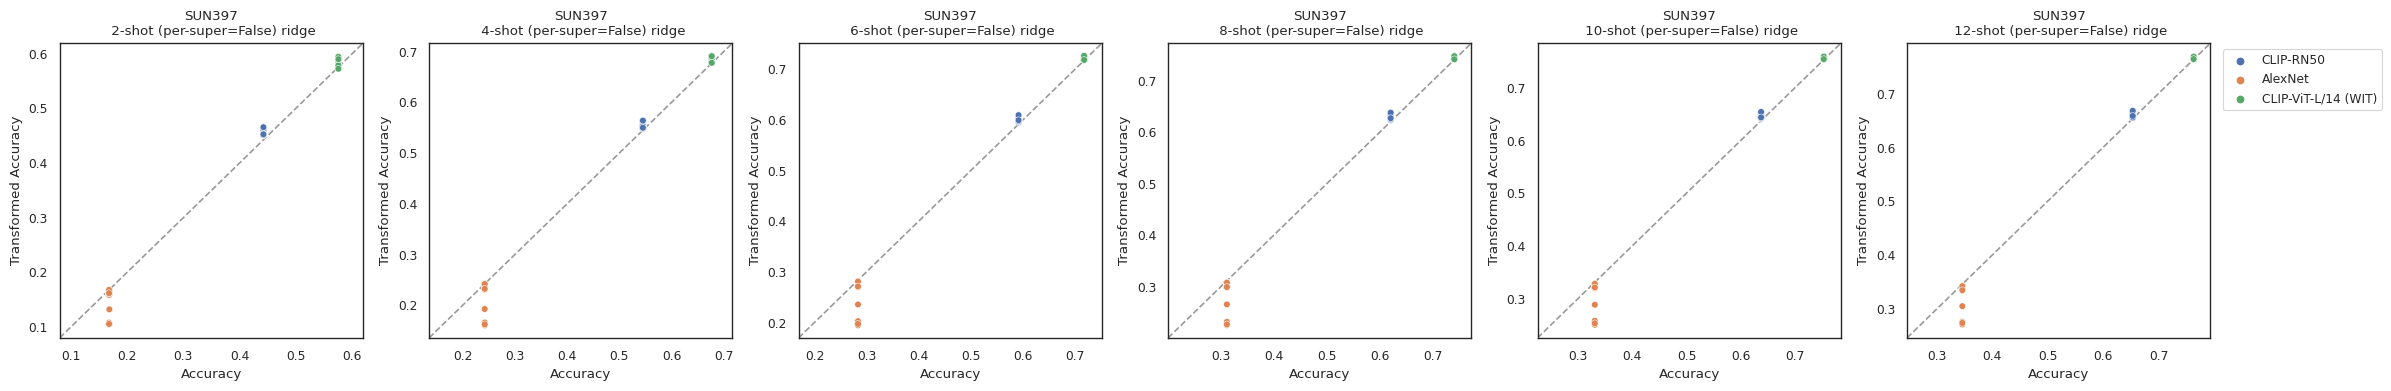

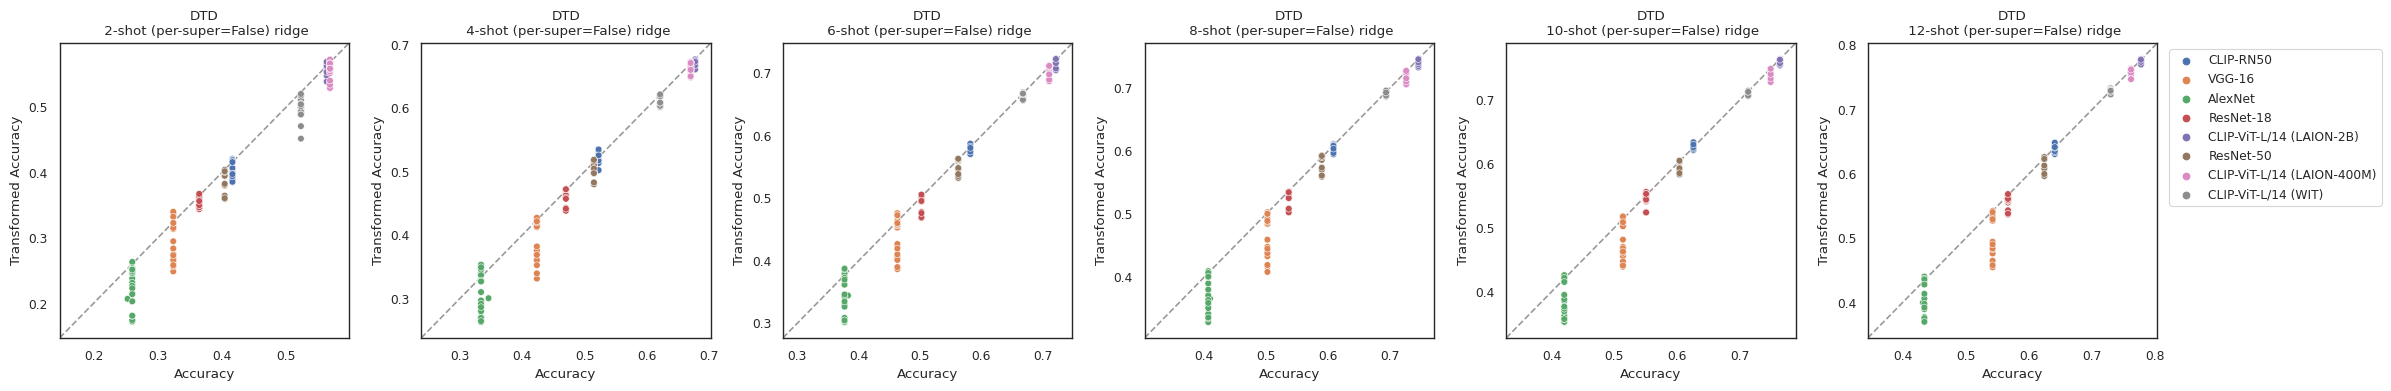

In [8]:
for data, task in zip(datas_fs, tasks_fs):
    plot_fs(data, task)

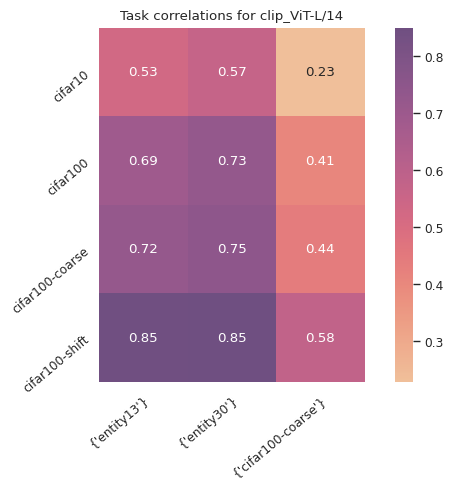

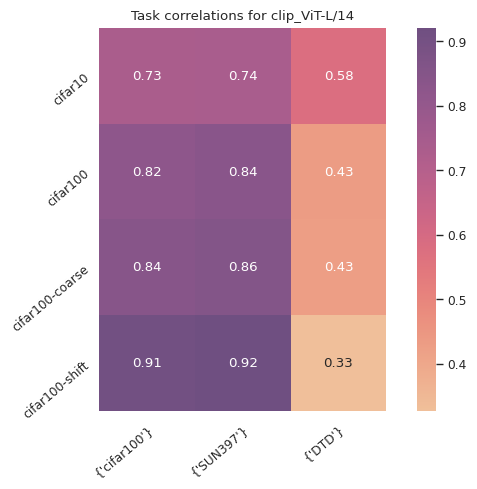

In [ ]:
plot_adfs_corr(datas_ad, tasks_ad, datas_fs_c, sps=True, n_shots=4, models=["clip_ViT-L/14"])
plot_adfs_corr(datas_ad, tasks_ad, datas_fs_f, sps=False, n_shots=4, models=["clip_ViT-L/14"])

In [ ]:
plot_fs_glob(datas_fs, datas_global_fs, tasks_fs, sps=True, n_shots=4, models=models)